## Metal plate and moving magnetic dipole  

We are solving the time dependent Maxwell's equations for linear motion at constant velocity 

find $u \in H(curl)$ such that
$$
\sigma\int \partial_t uv + \int \mu^{-1} \operatorname{curl} u \operatorname{curl} v = \int H_{ext} \operatorname{curl} v  
$$
for all $v \in H(curl)$.

Here the time-dependent external field is $$H_{ext}(t) = B_{dipole}(t)/\mu$$

Solve with implicit Euler time stepping. Inspired by the i-tutorial case "3.1 Parabolic model problem".

In [81]:
# Dipole location and strength
x_dp = -10
y_dp = 0
z_dp = 5
m_dp = 1 # dipole strength A/m^2
v_dp = 20 # dipole velocity m/s

In [82]:
%matplotlib widget

In [83]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import math
import numpy as np
import matplotlib.pyplot as plt

In [84]:
bkg = Box((-0.5,-0.5,-0.5), (0.5,0.5,0.5))
bkg.solids.name = "air"

plate = Box((-0.1,-0.1,-0.05),(0.1,0.1,0.05))
plate.maxh = 0.05
plate.solids.name = "metal"

bkg = bkg - plate

shape = Glue([bkg,plate])
mesh = Mesh(OCCGeometry(shape, dim=3).GenerateMesh(maxh=0.1))
Draw(mesh, clipping = { "pnt" : (0,0,0), "vec" : (1,0,0)},
     settings={"camera": {"transformations": [{"type": "rotateY", "angle": 90}, {"type": "rotateZ", "angle": 90}]}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'transformations':…

BaseWebGuiScene

In [85]:
mesh.GetMaterials()

('air', 'metal')

In [86]:
fes = HCurl(mesh, order = 3, nograds = False, complex = False) # natural boundary condition (no Dirichlet) when using external field
print ("ndof =", fes.ndof)
u,v = fes.TnT()
time = 0.0
dt = 0.05 # time step

ndof = 165828


In [87]:
mur = { "metal" : 1, "air" : 1, "default" : 1 }
sigma = {"metal": 3e7, "air": 1e-4, "default" : 1}
mu0 = 1.257e-6
nu_coef = [ 1/(mu0*mur[mat]) for mat in mesh.GetMaterials() ]
sigma_coef = [sigma[mat] for mat in mesh.GetMaterials() ]

sigma = CoefficientFunction(sigma_coef)
nu = CoefficientFunction(nu_coef)

In [88]:
# Initialize time parameter for stepping
t = Parameter(0.0)

Bilinear forms for a and m separately. 
Non-symmetric memory layout for the matrices so that a and m have the same sparsity pattern.

In [89]:
# LHS
a = BilinearForm(fes, symmetric=False)
a += nu*curl(u)*curl(v)*dx #+ 1e-7*nu*u*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += sigma*u*v*dx #+ 1e-7*sigma*u*v*dx
m.Assemble()

In [90]:
# RHS
# dipole directed in z-direction, moving in x-direction.
r = ((x-(x_dp+v_dp*t))**2+(y-y_dp)**2+(z-z_dp)**2)**(1/2)
Mx_dipole = m_dp*(3*(x-(x_dp+v_dp*t))*(z-z_dp)/r**5)/4/math.pi
My_dipole = m_dp*(3*(y-y_dp)*(z-z_dp)/r**5)/4/math.pi
Mz_dipole = m_dp*(3*(z-z_dp)**2/r**5-1/r**3)/4/math.pi
M_dipole = CoefficientFunction( (Mx_dipole,My_dipole,Mz_dipole) )  # Creates a vector CF

mag = mesh.MaterialCF({},default=M_dipole) # Magnetization or external field
ft = LinearForm(fes)
ft += mag*curl(v) * dx

gfu = GridFunction(fes)
gfu.Set((1e-10,1e-10,1e-10)) # Initial condition. Note that boundary conditions remain

## Implicit Euler method
$$
  \underbrace{(M + \Delta t A)}_{M^\ast} u^{n+1} = M u^n + \Delta tf^{n+1}
$$

or in an incremental form:

$$
  M^\ast (u^{n+1} - u^n) = - \Delta t A u^n + \Delta tf^{n+1}.
$$

* Incremental form: $u^{n+1} - u^n$ has homogeneous boundary conditions (unless boundary conditions are time-dependent).
* For the time stepping method: set up linear combinations of matrices.
* (Only) if the sparsity pattern of the matrices agree we can copy the pattern and sum up the entries.

First, we create a matrix of same format as m.mat and compare number of non-zero entries and sparsity pattern:

In [91]:
mstar = m.mat.CreateMatrix()
print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}, mstar.nze={mstar.nze}")
#print("sparsity pattern a.mat:")
#ShowPattern(a.mat,binarize=True)

m.mat.nze = 18042512, a.mat.nze=18042512, mstar.nze=18042512


To access the entries we use the vector of nonzero-entries:

In [92]:
print(f"mstar.nze={mstar.nze}, len(mstar.AsVector())={len(mstar.AsVector())}")

mstar.nze=18042512, len(mstar.AsVector())=18042512


Using the vector we can build the linear combination of the a and the m matrix:

In [93]:
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs()) # Takes a long time for large matrix.

In [94]:
scene1 = Draw((curl(gfu) - M_dipole*mu0)*1e9, mesh, clipping = { "pnt" : (0,0,0), "vec" : (1,0,0), "function":True,},
              autoscale=False,  min=0, max=3e-1, vectors = { "grid_size":50},
    settings={ "Colormap" : { "ncolors" : 32 },"camera": {"transformations": [{"type": "rotateY", "angle": 90}, {"type": "rotateZ", "angle": 90}]}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 32}, …

In [95]:
def TimeStepping_tdepRHS(invmstar, initial_cond = None, t0 = 0, tend = 2, 
                      nsamples = 10):
    t_list = []
    B_ind_list = []
    B_tot_list = []
    if initial_cond:
        gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(floor(tend / dt / nsamples)+1)
    gfut = GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)
    while time < tend - dt:    
        t.Set(time)
        ft.Assemble() # update the RHS
        res = dt * ft.vec - dt * a.mat * gfu.vec
        gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0: 
            # Output data at each time step... How is it accessed in post-processing? e.g. plotting in matplotlib.
            gfut.AddMultiDimComponent(gfu.vec)
            B_tot_tmp = curl(gfu)
            t_list.append(time)
            B_ind_list.append(np.array(B_tot_tmp(mesh(0,0,0)))-np.array(M_dipole(mesh(0,0,0)))*mu0)
            B_tot_list.append(B_tot_tmp(mesh(0,0,0)))
        cnt += 1; time = cnt * dt
        scene1.Redraw()
    return gfut, t_list, B_ind_list, B_tot_list

In [96]:
#help(GridFunction)
#help(Draw)

In [97]:
%%time
gfut_a2, t_list, B_ind_list, B_tot_list = TimeStepping_tdepRHS(invmstar, initial_cond=None, tend=1, nsamples = 40)

 0.95000000000000013CPU times: user 1min 4s, sys: 1.67 s, total: 1min 5s
Wall time: 30.2 s


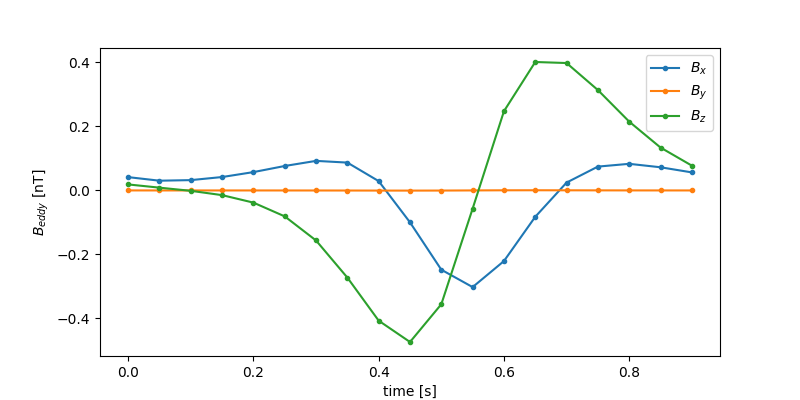

In [98]:
# plot B induced in the plate at origo for each time step.
fig = plt.figure(figsize=[8,4])
plt.plot(np.array(t_list), np.array(B_ind_list)*1e9, '.-')
plt.xlabel("time [s]")
plt.ylabel("$B_{eddy}$ [nT]")
plt.legend(["$B_x$", "$B_y$", "$B_z$"])

## Using iterative solver (Not working yet. Why?)

* For a factorization of $M^\ast$ (and ${M^\ast}^{-1}$) we required a sparse matrix $M^\ast$ 
* To store $M^\ast$ **as a sparse matrix** requires new storage (and same memory layout of $A$ and $M$)
* For iterative solvers we only require the matrix (and preconditioner) applications and it **suffices to have $M^\ast$ available as a linear operator**
* `mstar_alt = m.mat + dt * a.mat` has no storage but defines the operator action: sum of two matrix-vector multiplications

iterative solver version (with Jacobi preconditining):

In [45]:
mstar_alt = m.mat + dt * a.mat
premstar_alt = m.mat.CreateSmoother() + dt * a.mat.CreateSmoother()
print(premstar_alt)

Sum of
Scale a = 1
Print base-matrix
Scale b = 1
Scale with 0.01:
Print base-matrix



Now, replace the action of the inverse Matrix from the previous script with a solution of a conjugate gradient method:

In [23]:
from ngsolve.krylovspace import CGSolver
invmstar_alt = CGSolver(mstar_alt, premstar_alt, tol=1e-8, printrates="\r", maxiter=200)

In [24]:
%%time
#gfut_a1 = TimeStepping_tdepRHS(invmstar_alt, initial_cond=M_dipole_t0, tend=0.01, nsamples=5)
gfut_iter, t_list, B_ind_list, B_tot_list = TimeStepping_tdepRHS(invmstar_alt, initial_cond=None, tend=0.1)

CG converged in 200 iterations to residual nan


KeyboardInterrupt: 

In [184]:
Draw(gfut_iter*1e9, mesh)


TypeError: can't multiply sequence by non-int of type 'float'